In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import glob
from datetime import datetime
from pyhdf.SD import SD

import satpy
from satpy.scene import Scene
from satpy.utils import debug_on
from satpy import find_files_and_readers
import pyresample as prs
from satpy.writers import get_enhanced_image

# Python libraries for visualization
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

### Download Example Data File
https://ladsweb.modaps.eosdis.nasa.gov/search/order/3/MYD021KM--61/2017-10-06/DNB/Custom

In [2]:
file_name = glob.glob('/Users/anna.jungbluth/Downloads/MYD021KM.A2017279.0655.061.2017286154849.hdf')

### Loading Data using __Pyhdf__

In [3]:
hdf_file = SD(file_name[0])

#### Investigate Dataset Keys

In [4]:
datasets = hdf_file.datasets()
print(datasets.keys())

dict_keys(['Latitude', 'Longitude', 'EV_1KM_RefSB', 'EV_1KM_RefSB_Uncert_Indexes', 'EV_1KM_Emissive', 'EV_1KM_Emissive_Uncert_Indexes', 'EV_250_Aggr1km_RefSB', 'EV_250_Aggr1km_RefSB_Uncert_Indexes', 'EV_250_Aggr1km_RefSB_Samples_Used', 'EV_500_Aggr1km_RefSB', 'EV_500_Aggr1km_RefSB_Uncert_Indexes', 'EV_500_Aggr1km_RefSB_Samples_Used', 'Height', 'SensorZenith', 'SensorAzimuth', 'Range', 'SolarZenith', 'SolarAzimuth', 'gflags', 'EV_Band26', 'EV_Band26_Uncert_Indexes', 'Band_250M', 'Band_500M', 'Band_1KM_RefSB', 'Band_1KM_Emissive', 'Noise in Thermal Detectors', 'Change in relative responses of thermal detectors', 'DC Restore Change for Thermal Bands', 'DC Restore Change for Reflective 250m Bands', 'DC Restore Change for Reflective 500m Bands', 'DC Restore Change for Reflective 1km Bands'])


In [5]:
print('Bands measured at 250m: ', hdf_file.select('Band_250M').get())
print('Bands measured at 500m: ', hdf_file.select('Band_500M').get())
print('Bands measured at 1km: ', hdf_file.select('Band_1KM_RefSB').get())
print('Thermal bands measured at 1km: ', hdf_file.select('Band_1KM_Emissive').get())

Bands measured at 250m:  [1. 2.]
Bands measured at 500m:  [3. 4. 5. 6. 7.]
Bands measured at 1km:  [ 8.   9.  10.  11.  12.  13.  13.5 14.  14.5 15.  16.  17.  18.  19.
 26. ]
Thermal bands measured at 1km:  [20. 21. 22. 23. 24. 25. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.]


In [5]:
bands_1KM_RefSB = hdf_file.select('EV_1KM_RefSB').get()
bands_1KM_Emissive = hdf_file.select('EV_1KM_Emissive').get()

In [6]:
bands_1KM_RefSB[0] # This data was collected at night, and therefore contains fill values.

array([[65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       ...,
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535]], dtype=uint16)

In [7]:
bands_1KM_Emissive[0] # Emission data for the thermal bands can also be collected at night

array([[5649, 5649, 5679, ..., 4205, 4130, 4702],
       [5652, 5660, 5675, ..., 4163, 4365, 4867],
       [5675, 5675, 5668, ..., 4296, 4296, 4273],
       ...,
       [6270, 6914, 7274, ..., 6124, 6755, 6867],
       [6365, 6455, 7500, ..., 6490, 6897, 7319],
       [6133, 7014, 8014, ..., 6564, 6997, 7394]], dtype=uint16)

#### Example Plots

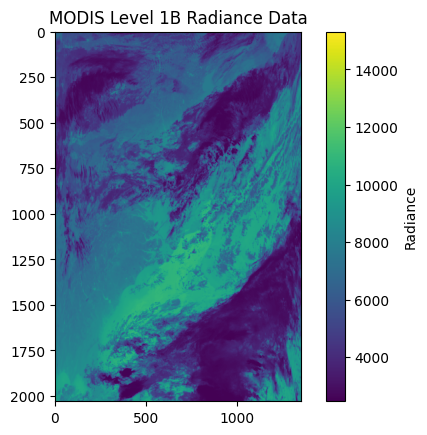

In [28]:
n = 2

# Plotting a sample image (adjust indices as needed)
plt.imshow(bands_1KM_Emissive[n])
plt.colorbar(label='Radiance')
plt.title('MODIS Level 1B Radiance Data')
plt.show()

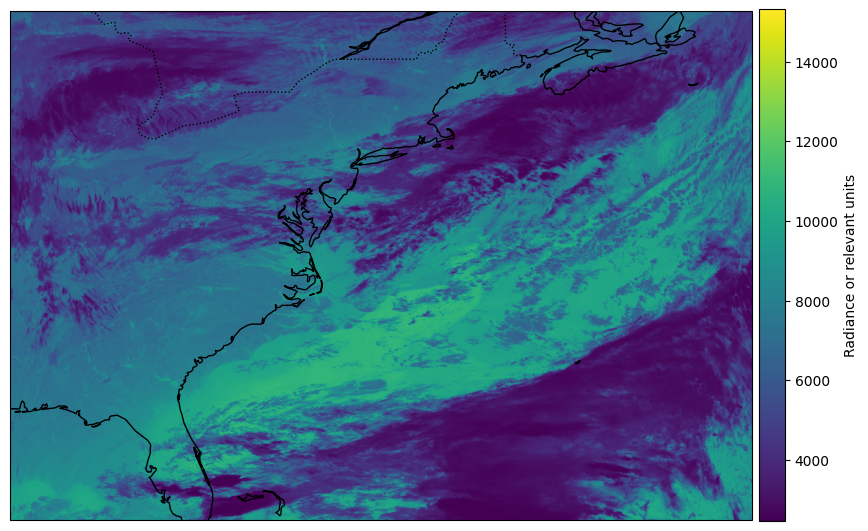

In [29]:
n = 2

# Get geospatial information
latitude = hdf_file.select('Latitude').get()
longitude = hdf_file.select('Longitude').get()

# Plot on a world map using cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot MODIS data on the world map
im = ax.imshow(bands_1KM_Emissive[n], extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
               cmap='viridis', origin='upper')

# Add coastlines and countries for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.033, pad=0.01)
cbar.set_label('Radiance or relevant units')

plt.show()

### Loading Data using __Satpy__

In [3]:
scn = Scene(filenames=file_name, reader='modis_l1b')
scn.all_dataset_names()

['1',
 '10',
 '11',
 '12',
 '13hi',
 '13lo',
 '14hi',
 '14lo',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'latitude',
 'longitude',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'solar_azimuth_angle',
 'solar_zenith_angle']

In [113]:
scn.available_composite_ids()

Too many possible datasets to load for DataQuery(wavelength=0.67)


[DataID(name='airmass'),
 DataID(name='ash'),
 DataID(name='day_essl_colorized_low_level_moisture'),
 DataID(name='day_essl_low_level_moisture'),
 DataID(name='day_microphysics'),
 DataID(name='dust'),
 DataID(name='essl_colorized_low_level_moisture'),
 DataID(name='essl_low_level_moisture'),
 DataID(name='fog'),
 DataID(name='green_snow'),
 DataID(name='ir108_3d'),
 DataID(name='ir_cloud_day'),
 DataID(name='natural_color'),
 DataID(name='natural_color_raw'),
 DataID(name='natural_with_night_fog'),
 DataID(name='night_fog'),
 DataID(name='ocean_color'),
 DataID(name='overview'),
 DataID(name='snow'),
 DataID(name='true_color'),
 DataID(name='true_color_crefl'),
 DataID(name='true_color_thin'),
 DataID(name='true_color_uncorrected')]